In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')

In [18]:
prices = pd.read_csv('/Users/ainabukeyeva/Downloads/crypto_prices.csv')
news = pd.read_csv('/Users/ainabukeyeva/Downloads/crypto_news.csv')
prices['date'] = pd.to_datetime(prices['date'])
news['date'] = pd.to_datetime(news['date'])
prices.head()

,date,symbol,open,high,low,close,volume
0,2023-01-01,BTC,550.35,555.44,549.25,554.67,58708016.74
1,2023-01-02,BTC,552.78,553.05,544.50,544.89,12883086.91
2,2023-01-03,BTC,548.11,551.49,541.73,546.33,52958955.82
3,2023-01-04,BTC,545.34,552.11,540.60,548.04,57796910.14
4,2023-01-05,BTC,543.38,545.38,532.06,534.86,86701917.33


In [20]:
print(prices.columns)

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume'], dtype='object')


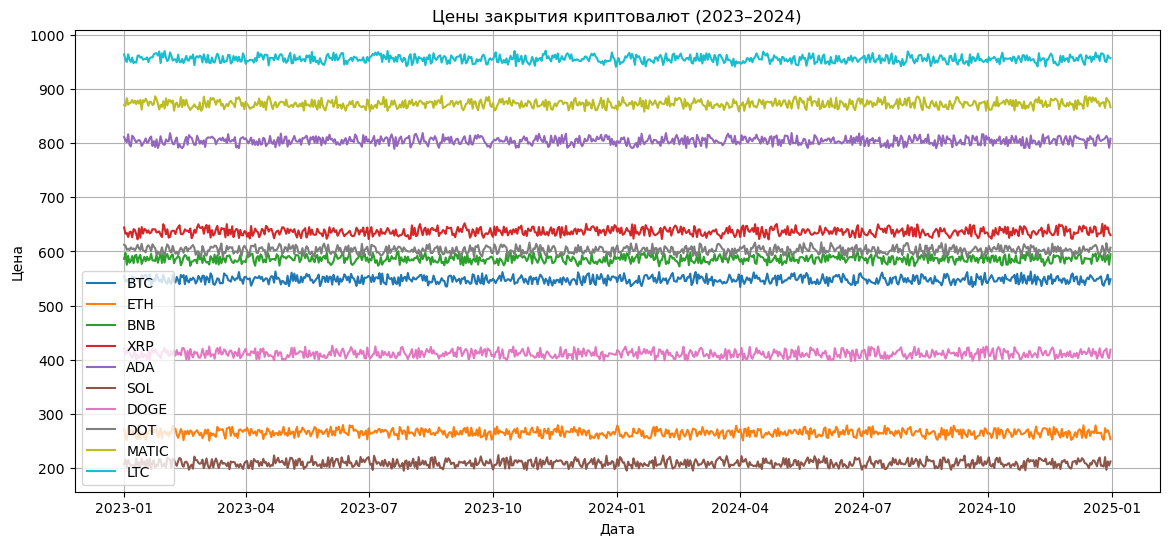

In [22]:
plt.figure(figsize=(14,6))
for sym in prices['symbol'].unique():
    subset = prices[prices['symbol'] == sym]
    plt.plot(subset['date'], subset['close'], label=sym)
plt.legend()
plt.title('Цены закрытия криптовалют (2023–2024)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True)
plt.show()

In [32]:
daily_news = news.groupby('date')['title'].apply(lambda x: ' '.join(x)).reset_index()
daily_news.head()

,date,title
0,2023-01-01,Sample crypto news headline for ADA on 2023-01...
1,2023-01-02,Sample crypto news headline for LTC on 2023-01-02
2,2023-01-03,Sample crypto news headline for DOT on 2023-01...
3,2023-01-04,Sample crypto news headline for BTC on 2023-01-04
4,2023-01-05,Sample crypto news headline for SOL on 2023-01...


In [34]:
vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = vectorizer.fit_transform(daily_news['title'])
svd = TruncatedSVD(n_components=1)
daily_news['sentiment_index'] = svd.fit_transform(X_tfidf)
daily_news.head()

,date,title,sentiment_index
0,2023-01-01,Sample crypto news headline for ADA on 2023-01...,0.459332
1,2023-01-02,Sample crypto news headline for LTC on 2023-01-02,0.551798
2,2023-01-03,Sample crypto news headline for DOT on 2023-01...,0.582385
3,2023-01-04,Sample crypto news headline for BTC on 2023-01-04,0.551088
4,2023-01-05,Sample crypto news headline for SOL on 2023-01...,0.595921


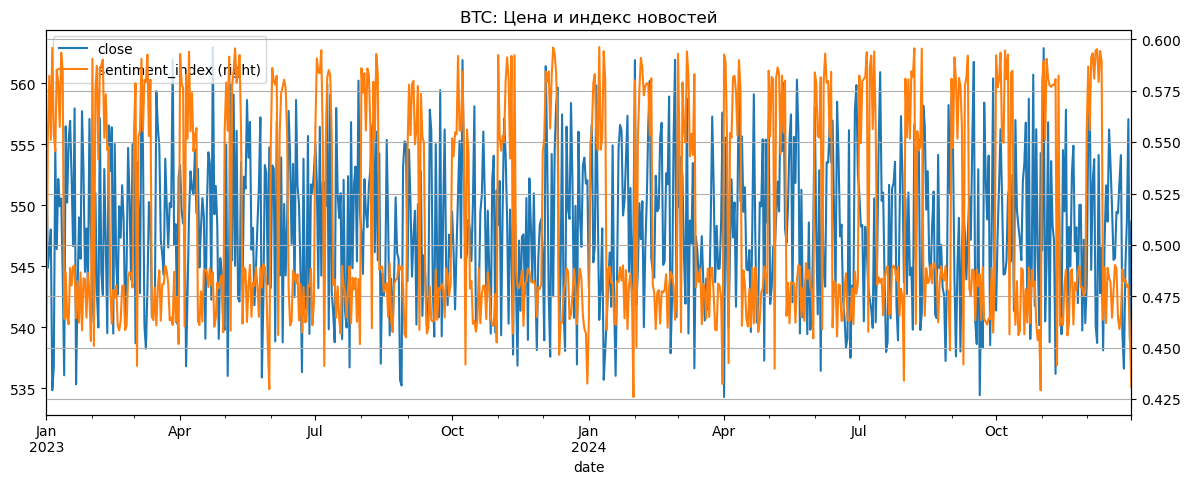

In [36]:
merged = prices[prices['symbol'] == 'BTC'].merge(daily_news, on='date', how='left')
merged = merged.fillna(method='ffill')
merged.set_index('date', inplace=True)
merged[['close', 'sentiment_index']].plot(figsize=(14,5), secondary_y='sentiment_index')
plt.title('BTC: Цена и индекс новостей')
plt.grid(True)
plt.show()

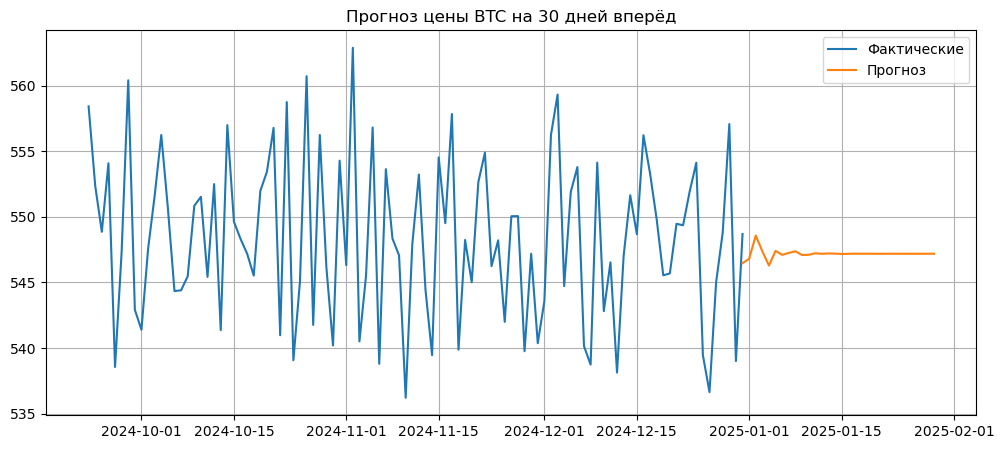

In [30]:
endog = merged['close']
exog = merged[['sentiment_index']]
model = sm.tsa.ARIMA(endog, order=(5,1,0), exog=exog).fit()
forecast = model.forecast(steps=30, exog=np.tile(exog.values[-1:], (30,1)))
plt.figure(figsize=(12,5))
plt.plot(endog[-100:], label='Фактические')
plt.plot(pd.date_range(endog.index[-1], periods=30, freq='D'), forecast, label='Прогноз')
plt.title('Прогноз цены BTC на 30 дней вперёд')
plt.legend()
plt.grid(True)
plt.show()